## Import necessary python libraries and custom functions

In [1]:
import os
import time
import glob
import pickle
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from common_functions import * # import custom functions
from extraction_functions import *
%matplotlib inline

## Feature extraction parameters
color_space = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9               # HOG orientations
pix_per_cell = 8         # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = "ALL"      # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32           # Number of histogram bins
#############################

### Image dataset reading

In [ ]:
# Read in car and non-car images which are already in separate folders
### car data is placed in six folders and 
### notcar data is placced in two folders
car_paths = ['data/vehicles/KITTI_extracted/*.png',
             'data/vehicles/GTI_Far/*.png',
             'data/vehicles/GTI_Left/*.png',
             'data/vehicles/GTI_Right/*.png',
             'data/vehicles/GTI_MiddleClose/*.png',
             'data/vehicles/Additional/*.png']

notcar_paths = ['data/non-vehicles/Extras/*.png',
                'data/non-vehicles/GTI/*.png']

cars = []
notcars = []

# store actual image paths in their respective lists
# car image files
for car_path in car_paths:
    car_images = glob.glob(car_path)
    for car_image in car_images:
        cars.append(car_image)
# notcar image files
for notcar_path in notcar_paths:
    notcar_images = glob.glob(notcar_path)
    for notcar_image in notcar_images:
        notcars.append(notcar_image)

print('Number of car images:',len(cars))
print('Number of noncar images:',len(notcars))

### Visualize data samples

In [ ]:
# Get one of the images from the dataset randomly
index = np.random.randint(0,len(cars))
car_img = plt.imread(cars[index])
notcar_img = plt.imread(notcars[index])
#Show the images
plt.figure()
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(car_img)
plt.subplot(122)
plt.title('Non-vehicle')
plt.imshow(notcar_img)

In [ ]:
#Visualize what the hog features look like. By setting vis=True, get_hog_features() returns the hog_image
features_car, car_hog_img = get_hog_features(cv2.cvtColor(car_img,cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features_ncar, notcar_hog_img = get_hog_features(cv2.cvtColor(notcar_img,cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.figure(figsize=(6,6))
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(car_img)
plt.subplot(122)
plt.title('Hog image for car')
plt.imshow(car_hog_img)

plt.figure(figsize=(6,6))
plt.subplot(121)
plt.title('Non-vehicle')
plt.imshow(notcar_img)
plt.subplot(122)
plt.title('Hog image for notcar')
plt.imshow(notcar_hog_img)

### Training the SVC linear model

In [ ]:
## Get the features vector

t = time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel) 
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                   hog_channel=hog_channel) 
t2 = time.time()
print('Time taken to extract features: ', round(t2 - t, 2), 'Seconds.')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Time taken to train SVC: ', round(t2 - t, 2), 'Seconds.')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

## save the model in the disk for later use
with open('svc_model.pkl', 'wb') as sv_model:
    pickle.dump((svc,X_scaler),sv_model)


### Test on test images

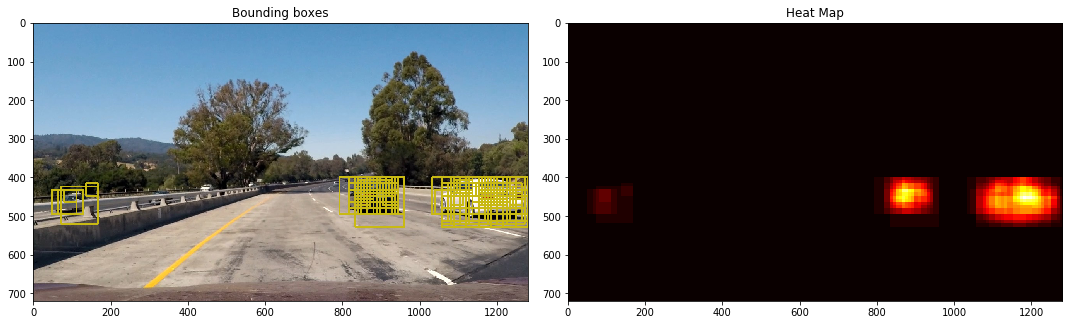

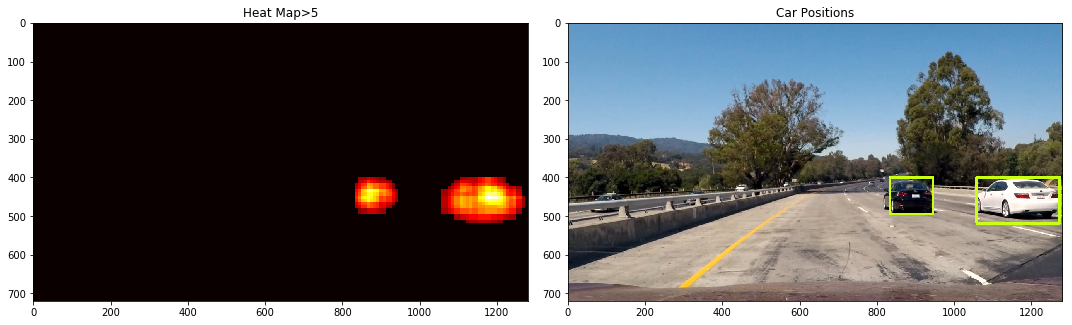

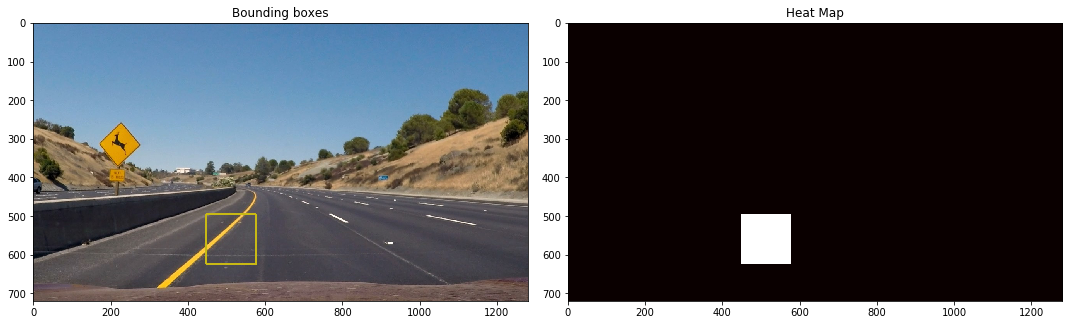

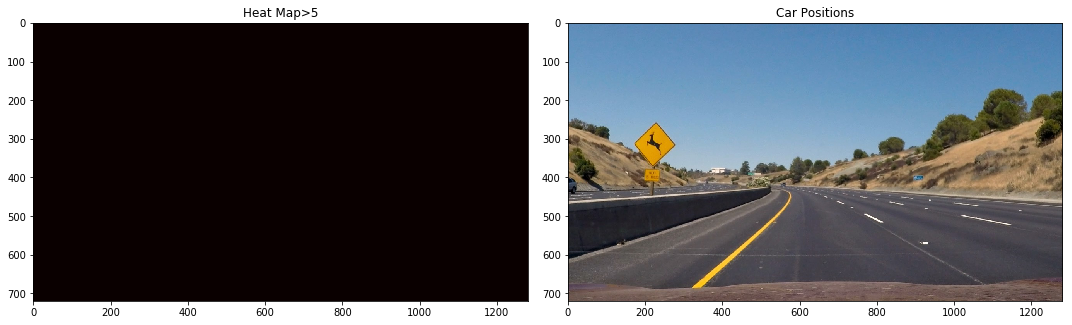

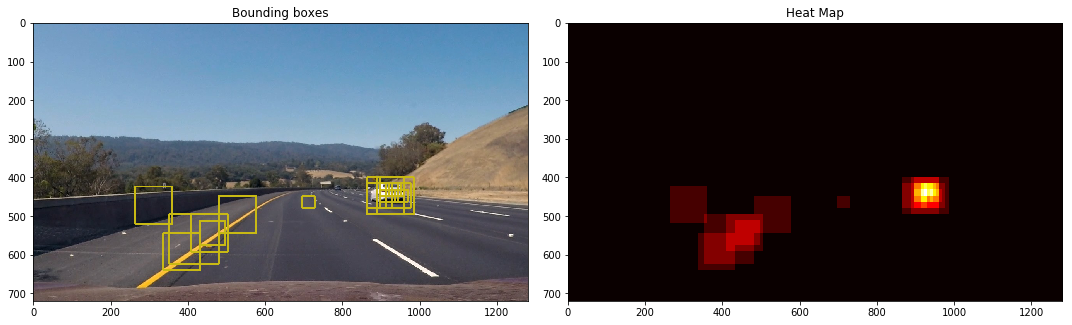

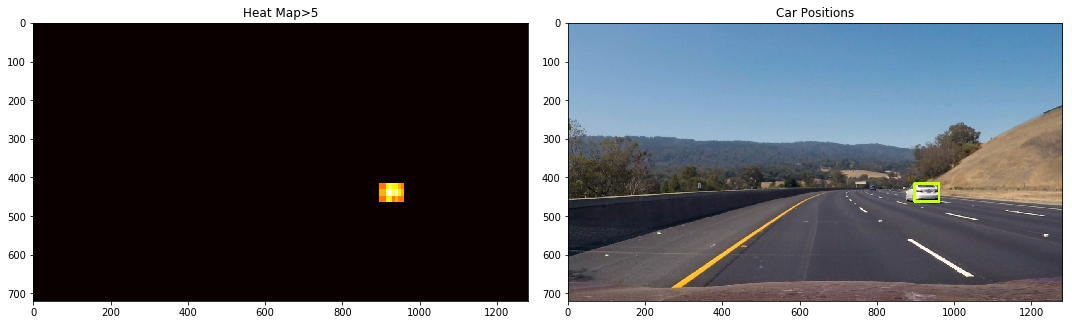

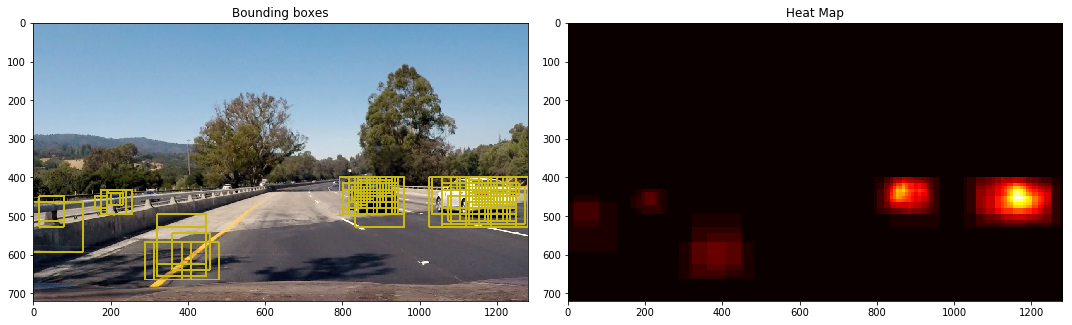

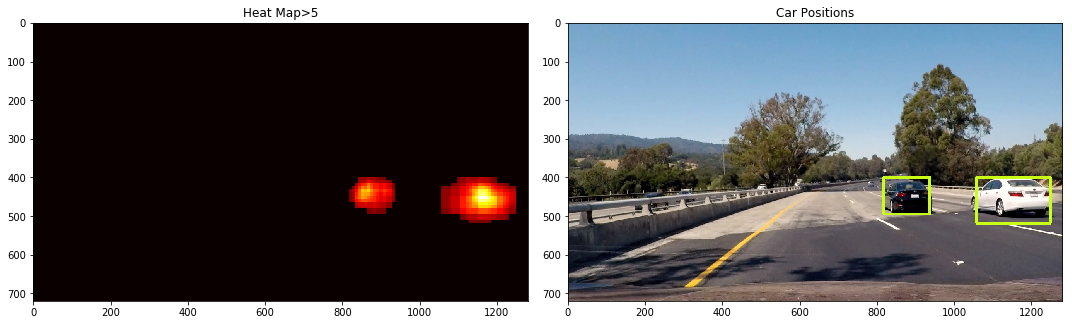

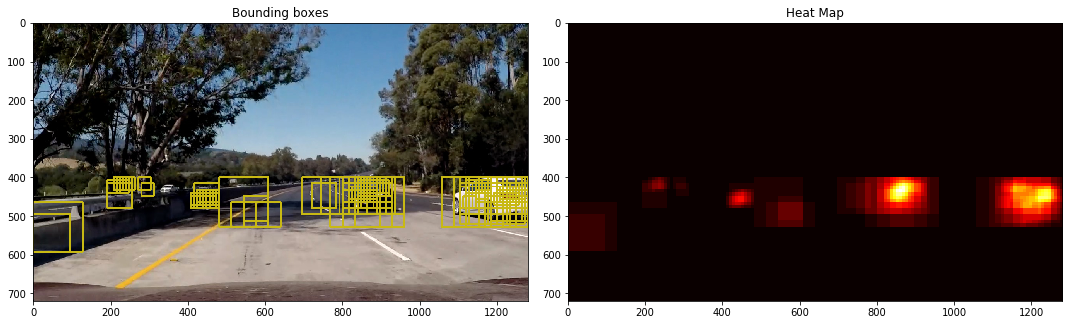

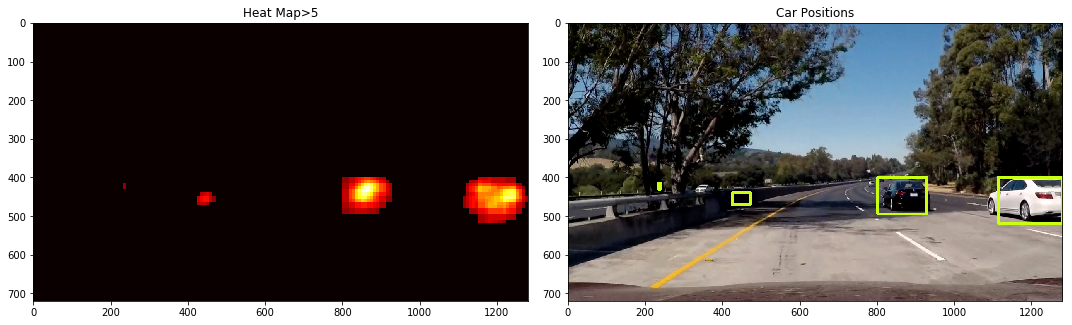

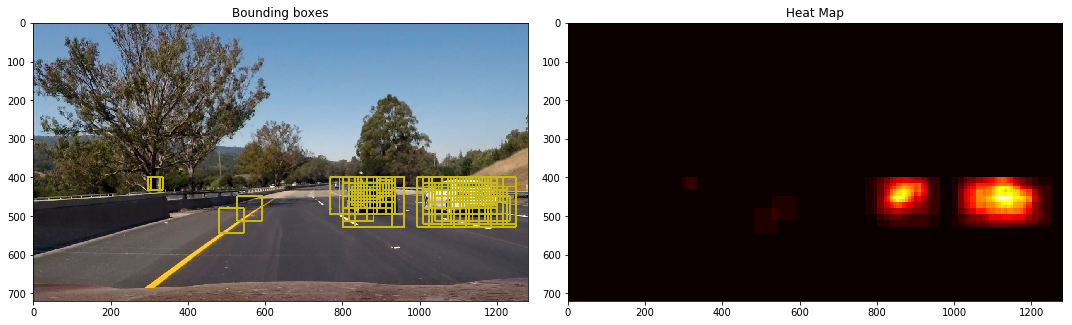

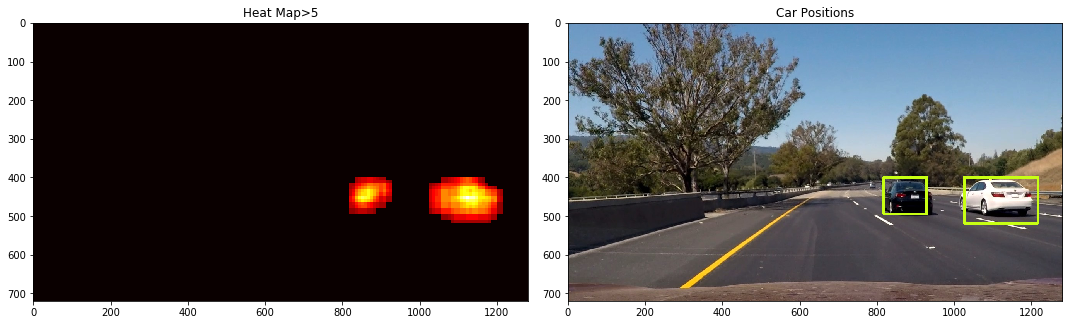

In [2]:
### Load the svm model
with open('svc_model.pkl','rb') as svc_model:
    svc, X_scaler = pickle.load(svc_model)

# Test the classifier with the test images
test_img_dir = "test_images/"
img_paths = os.listdir(test_img_dir)

for f_name in img_paths:
    if 'jpg' in f_name:
        img = cv2.imread(test_img_dir+f_name)
        image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        scales =[0.5,1,1.5,2.0]
        ystart =[400,400,400,400]
        ystop =[480,600,680,680]
        heat_thresh = 5
       
        final_img, img_bboxes,heat,heatmap,bboxes = predict_vehicle(img, svc, X_scaler, scales, ystart, ystop,color_space,
                                               orient, pix_per_cell, cell_per_block,spatial_size, hist_bins, heat_thresh)
        
        
        # To see the search windows 
        # img_with_boxes = np.copy(image)
        # for i in range(len(bboxes)):    
        #     img_with_boxes=draw_boxes(img_with_boxes, bboxes, color=(np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)), thick=3)
        
        # plt.figure(figsize=(10,10))
        # plt.title('Searching grid')
        # plt.imshow(img_with_boxes)

        fig = plt.figure(figsize=(15,15))
        plt.subplot(121)
        plt.title('Bounding boxes')
        plt.imshow(cv2.cvtColor(img_bboxes,cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(heat, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        
        fig = plt.figure(figsize=(15,15))
        plt.subplot(121)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map>5')
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB))
        plt.title('Car Positions')
        fig.tight_layout()


### HOG classifier

In [ ]:
## Tweak these parameters and see how the results change.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins

### Load the svm model
with open('svc_model.pkl','rb') as svc_model:
    svc, X_scaler = pickle.load(svc_model)

#X_scaler = vectorizer
scales =[0.5,1,1.5,2.0]
ystart =[400,400,400,400]
ystop =[480,600,680,680]
heat_thresh = 5
# scales =[1.0,1.5]
# ystart =[400,400]
# ystop = [550,680]
# heat_thresh = 3

#Read the video file
cap = cv2.VideoCapture("project_video.mp4")

# Define the codec, frame size, frames per second and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
frame_size = (int(cap.get(3)),int(cap.get(4)))
fps = cap.get(5)
f_name = str(time.time())

#Create video writer object to create/save processed video
out = cv2.VideoWriter('output_video_'+f_name+'.avi',fourcc, fps, frame_size)
#out2 = cv2.VideoWriter('bounding_boxes_'+f_name+'.avi',fourcc, fps, frame_size)
print('Processing ...')
#count number of frames
num_of_frames =0
t = time.time()
while(cap.isOpened()):
    ret, image = cap.read()
    if ret==True:
        num_of_frames += 1
        
        #image = frame#cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) 
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        
        final_img, img_bboxes,heatmap,bboxes = predict_vehicle(image, svc, X_scaler, scales[1:3], ystart, ystop,color_space,
                                       orient, pix_per_cell, cell_per_block,spatial_size, hist_bins, heat_thresh)
    
        out.write(final_img) # image after false detection removal
        #out2.write(img_bboxes) # image with all predicted bounding boxes 

    else:
        break
t2 = time.time()
print('Time taken to predict:', round(t2 - t, 2), 'Seconds.')
# Release everything if job is finished
cap.release()
out.release()
#out2.release()

print('Process completed. \nTotal number of frames processed: {}.'.format(num_of_frames))
